# Project TOPAZ against an other grid

## Here for Bocquet 2023 (Envisat/ERS1/ERS2 Resolution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import datetime
from dateutil.relativedelta import relativedelta

from src.utils import modif_plot

# Project on TOPAZ grid

In [2]:
import pyproj
from src.modules.grid.grid import Grid
from src.modules.topaz.v4.confmap import ConformalMapping

In [4]:
# load information for TOPAZ grid
cm = ConformalMapping.init_from_file('/users/edelleo1/tardis/tardis-ml/src/modules/grid.info')

nx = cm._ires
ny = cm._jres

ii, jj = np.meshgrid(np.arange(nx), np.arange(ny))
lat, lon = cm.gind2ll(ii+1., jj+1.)

# ##find grid resolution
geod = pyproj.Geod(ellps='sphere')
_,_,dist_x = geod.inv(lon[:,1:], lat[:,1:], lon[:,:-1], lat[:,:-1])
_,_,dist_y = geod.inv(lon[1:,:], lat[1:,:], lon[:-1,:], lat[:-1,:])
dx = np.median(dist_x)
dy = np.median(dist_y)

##the coordinates in topaz model native grid
x = ii*dx
y = jj*dy

##proj function that mimic what pyproj.Proj object does to convert x,y to lon,lat
def proj(x, y, inverse=False):
    if not inverse:
        i, j = cm.ll2gind(y, x)
        xo = (i-1)*dx
        yo = (j-1)*dy
    else:
        i = np.atleast_1d(x/dx + 1)
        j = np.atleast_1d(y/dy + 1)
        yo, xo = cm.gind2ll(i, j)
    if xo.size == 1:
        return xo.item(), yo.item()
    return xo, yo

# TOPAZ grid

#### Jiping used ANOTHER GRID for my version of TOPAZ

In [3]:
in_proj = pyproj.Proj('+proj=stere +lon_0=-45 +lat_0=90 +k=1 +R=6378273 +no_defs')

In [4]:
ifile = '/scratch/project_465000269/edelleo1/Leo/Jiping_2023/TP4b/20221231_dm-12km-NERSC-MODEL-TOPAZ4B-ARC-RAN.fv2.0.nc'

In [5]:
nc_tp = nc4.Dataset(f'{ifile}', mode='r')
sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_tp))['sithick']

In [6]:
# get x, y
data_gx, data_gy = np.meshgrid(sit.x.to_numpy(), sit.y.to_numpy())

## Import ERS1 grid (same for the whole Bocquet dataset)

In [7]:
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/Bocquet_2023_SIT_climate_record/'
ofile_e1 = 'ERS1/SIT_nh_ers1_199410_199604.nc'

In [8]:
nc = xr.open_mfdataset(f'{odir}{ofile_e1}', combine='nested', concat_dim='time')
sit_e1 = nc['sea_ice_thickness']

In [9]:
glat = nc['lat']
glon = nc['lon']

In [10]:
t_proj = pyproj.Proj('+proj=laea +lon_0=0 +lat_0=90 +lat_ts=0')

In [11]:
# Grid parameters 

# pixel size x 12500
# pixel size y 12500
# nb pixels x = 712
# nb pixels y = 712

In [12]:
xt_1d = np.arange(-12500*356, 12500*356, 12500)
yt_1d = np.arange(-12500*356, 12500*356, 12500)

In [13]:
xt, yt = np.meshgrid(xt_1d, yt_1d)

In [14]:
t_grid = Grid(t_proj, xt, yt)

# Convert TOPAZ with grid (Yue's module)

In [15]:
# create gridx, gridy (TOPAZ) - in meters already
# in_proj(glon[0][0], glat[0][0])
xp, yp = in_proj(glon, glat)

In [16]:
data_in = sit[0].to_numpy()

In [17]:
d_grid = Grid(in_proj, data_gx*100000, data_gy*100000)

In [18]:
# define destination grid
d_grid.dst_grid = t_grid

In [19]:
# convert data
data_out = d_grid.convert(data_in)

In [ ]:
from pyroutine.grid_TP_to_Bocquet23 import convert_alldayslldays as conv

Import...
Old config files, some <ml> parameters are not imported.
	1991-1998


In [46]:
data_incut = sit[0, 150:629,100:550].to_numpy()

In [45]:
# get x, y
data_gxc, data_gyc = np.meshgrid(sit.x[100:550].to_numpy(), sit.y[150:629].to_numpy())

In [47]:
d_gridc = Grid(in_proj, data_gxc*100000, data_gyc*100000)

In [49]:
d_gridc.dst_grid = t_grid

In [51]:
data_outc = d_gridc.convert(data_incut)

In [35]:
sit[0]

<xarray.DataArray 'sithick' (y: 881, x: 609)>
[536529 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2022-12-31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
  * x          (x) float32 -38.0 -37.88 -37.75 -37.62 ... 37.62 37.75 37.88 38.0
  * y          (y) float32 -55.0 -54.88 -54.75 -54.62 ... 54.62 54.75 54.88 55.0
Attributes:
    cell_methods:   area: mean where sea_ice
    grid_mapping:   stereographic
    standard_name:  sea_ice_thickness
    units:          m

In [31]:
data_out.shape

(712, 712)

# Plots

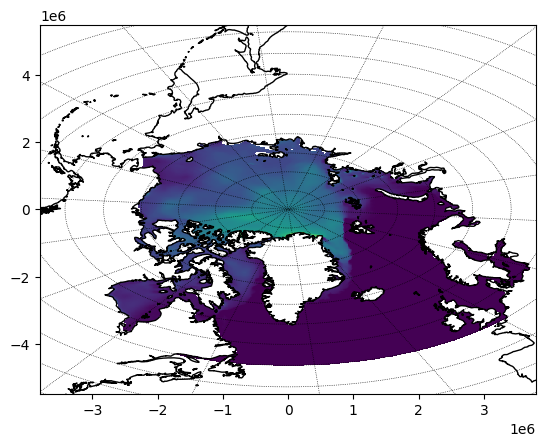

In [20]:
fig, ax = plt.subplots(1,1)
d_grid.plot_land(ax)
d_grid.plot_field(ax, data_in)

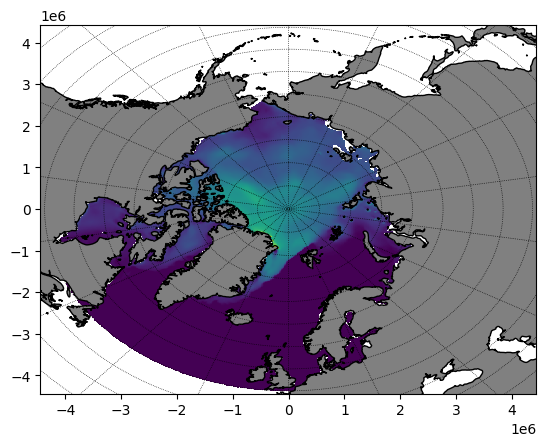

In [21]:
fig, ax = plt.subplots(1,1)
t_grid.plot_land(ax, color='grey')
t_grid.plot_field(ax, data_out)

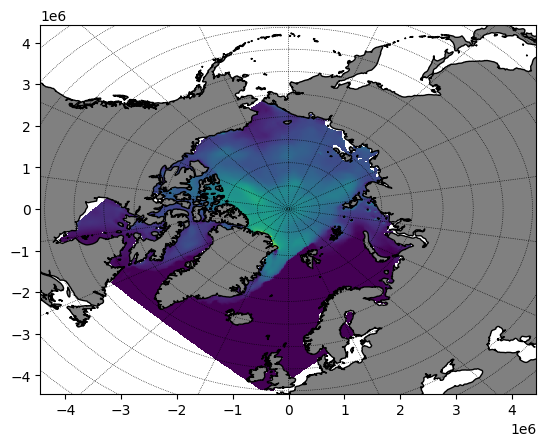

In [52]:
fig, ax = plt.subplots(1,1)
t_grid.plot_land(ax, color='grey')
t_grid.plot_field(ax, data_outc)

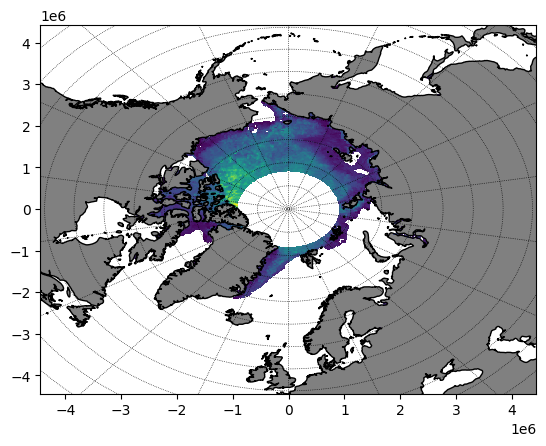

In [22]:
fig, ax = plt.subplots(1,1)
t_grid.plot_land(ax, color='grey')
t_grid.plot_field(ax, sit_e1.isel(time=0, y=slice(None,None,-1)))

## Post process on TOPAZ projected data

- Need to put Nan when SIT < 0
- Add Pole Hole: maximum latitude is 81.5*N. 82*N is used due to the grid
- monthly mean

and save dataset:
TOPAZ4_ML_pBocquet.nc

In [26]:
# fake time for now
chrono = sit_e1.time.isel(time=slice(None,1)).data
chrono

array(['1994-10-15T00:00:00.000000000'], dtype='datetime64[ns]')

In [27]:
# fake time axis too. using np.newaxis

In [28]:
da_sit = xr.DataArray(
    data=data_out[np.newaxis,:,:],
    dims=["time", "y", "x"],
    coords=dict(
        time=(["time"], chrono),
        x=(["x"], range(712)),
        y=(["y"], range(712))
    ),
    attrs=dict(
        name="Sea ice thickness",
        description="TOPAZ4b ML-adjusted projected on Bocquet et al. 2023 grid",
        project='TARDIS',
        units="m",
    ),
)

da_sit.name = 'sithick'

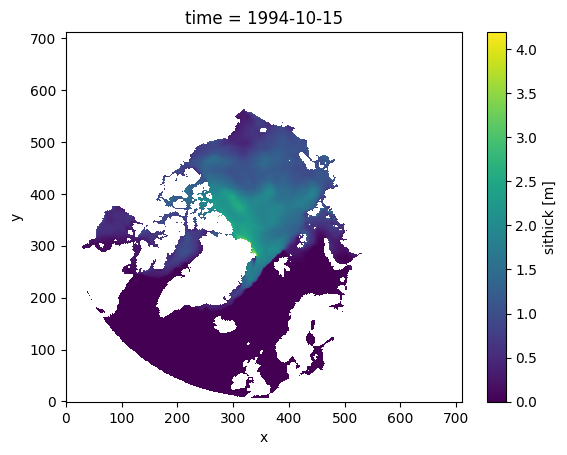

In [29]:
da_sit.isel(time=0, y=slice(None,None,-1)).plot()

In [30]:
# put Nan where SIT <= 0
sit_pp = da_sit.where(da_sit.isel(time=0)>0) # .isel(time=0, y=slice(None,None,-1))

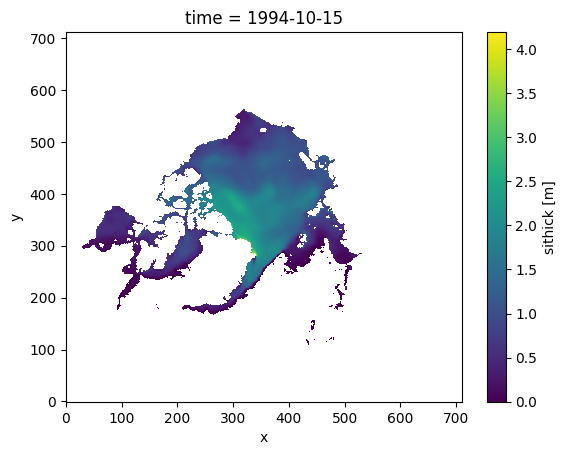

In [31]:
sit_pp.plot()

In [32]:
# Mask for Pole Hole: max latitude = 81.5  > 82

In [54]:
mask_hole = glat.where(glat>82)

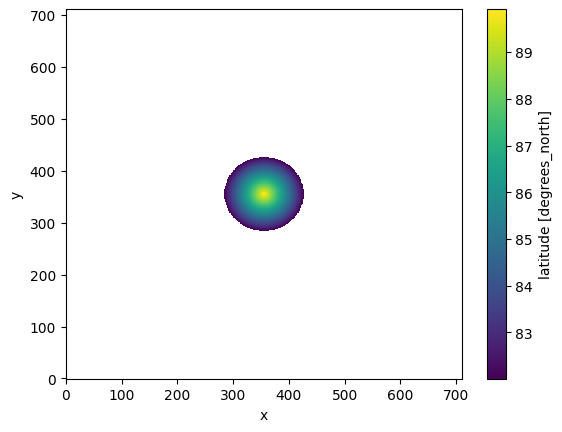

In [56]:
mask_hole.plot()

In [34]:
sit_pp = sit_pp.where(np.isnan(mask_hole))

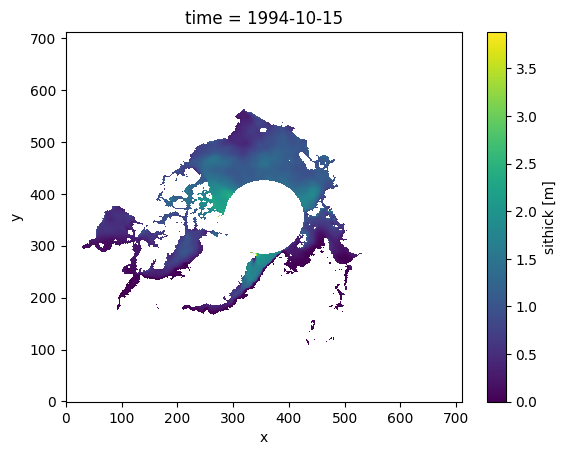

In [35]:
sit_pp.plot()

In [36]:
sit_e1

<xarray.DataArray 'sea_ice_thickness' (time: 14, y: 712, x: 712)>
dask.array<open_dataset-889228a0df82005e9a840ff64c1eed92sea_ice_thickness, shape=(14, 712, 712), dtype=float32, chunksize=(14, 712, 712), chunktype=numpy.ndarray>
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(712, 712), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(712, 712), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1994-10-15 ... 1996-04-15
    projection_x_coordinate  (x) float32 dask.array<chunksize=(712,), meta=np.ndarray>
    projection_y_coordinate  (y) float32 dask.array<chunksize=(712,), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    standard_name:  sea_ice_thickness
    long_name:      sea_ice_thickness
    comment:        Weighted mean sea ice thickness computed from radar freeb...
    units:          m

In [37]:
sit_pp

<xarray.DataArray 'sithick' (time: 1, y: 712, x: 712)>
dask.array<where, shape=(1, 712, 712), dtype=float64, chunksize=(1, 712, 712), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) datetime64[ns] 1994-10-15
  * x                        (x) int64 0 1 2 3 4 5 6 ... 706 707 708 709 710 711
  * y                        (y) int64 0 1 2 3 4 5 6 ... 706 707 708 709 710 711
    lat                      (y, x) float32 dask.array<chunksize=(712, 712), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(712, 712), meta=np.ndarray>
    projection_x_coordinate  (x) float32 dask.array<chunksize=(712,), meta=np.ndarray>
    projection_y_coordinate  (y) float32 dask.array<chunksize=(712,), meta=np.ndarray>
Attributes:
    name:         Sea ice thickness
    description:  TOPAZ4b ML-adjusted projected on Bocquet et al. 2023 grid
    project:      TARDIS
    units:        m

# Now just need to do it over monthly mean for all years

In [ ]:
## Import all TOPAZ ML-adjusted

In [2]:
import pandas as pd

In [3]:
from src.data_preparation import merge_TOPAZ

In [ ]:
sit_ml, chrono_ml = merge_TOPAZ.load()

In [4]:
ifolder = '/scratch/project_465000269/edelleo1/Leo/results/lstm_231212-183758/ml/'
ifile = 'sit_gLSTM3_bk_2011_2022_01.nc'

In [7]:
nc = nc4.Dataset(f'{ifolder}{ifile}', mode='r')
X = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit_ml']
chrono = pd.DataFrame({'date':pd.to_datetime(X['time'].to_numpy())})

In [36]:
X

<xarray.DataArray 'sit_ml' (time: 4383, y: 479, x: 450)>
[944755650 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2022-12-31
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -36.25 -36.12 -36.0 -35.88 ... 23.12 23.25 23.38 23.5
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...

In [72]:
chrono.iloc[0].date.strftime("%Y%m%d")

'20110101'

In [61]:
sit.time[0].strftime('%Y')

AttributeError: 'DataArray' object has no attribute 'strftime'

In [38]:
sit[:, 150:629,100:550]

<xarray.DataArray 'sithick' (time: 1, y: 479, x: 450)>
[215550 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2022-12-31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -36.25 -36.12 -36.0 -35.88 ... 23.12 23.25 23.38 23.5
Attributes:
    cell_methods:   area: mean where sea_ice
    grid_mapping:   stereographic
    standard_name:  sea_ice_thickness
    units:          m

# Monthly mean

In [74]:
from src.feature_extraction import monthly_mean_TP as mm

In [35]:
from importlib import reload

In [61]:
reload(mm)

<module 'src.feature_extraction.monthly_mean_TP' from '/users/edelleo1/tardis/tardis-ml/src/feature_extraction/monthly_mean_TP.py'>

In [75]:
sit_mm = mm.compute_mm(X)

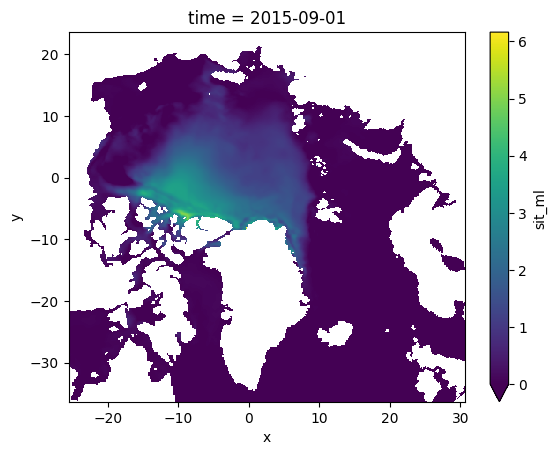

In [63]:
sit_mm.isel(time=56).plot(vmin=0)

In [77]:
chrono_mm = pd.DataFrame({'date':pd.to_datetime(sit_mm.time.to_numpy())})

In [78]:
chrono_mm

,date
0,2011-01-01
1,2011-02-01
2,2011-03-01
3,2011-04-01
4,2011-05-01
...,...
139,2022-08-01
140,2022-09-01
141,2022-10-01
142,2022-11-01


In [79]:
## Return a different index for each month

mon_idx = 0  # init first month as index 0
indexes = [mon_idx]  # first day of the first month

last_month = chrono.date[0].month  # month [1-12] at t-1

for i in range(1, len(chrono)):  # loop over days
    
    if last_month != chrono.date[i].month:  # if month is different
        mon_idx += 1                        # increments month index
        
    indexes += [mon_idx]                    # save month index
    last_month = chrono.date[i].month       # update month [1-12]
    
mon_indexes = np.array(indexes)

In [ ]:
## Average all days that have the same index = monthly mean

n_months = np.unique(mon_indexes).size
mon_mean = np.zeros((n_months, 479, 450), dtype=np.float16)
mon_chrono = []

for n, idx in enumerate(np.unique(mon_indexes)):          # loop over unique month index
    tmp_idx = np.where(mon_indexes==idx)[0]               # get locations of a given month index
    mon_mean[n] = X.isel(time=tmp_idx).mean('time')       # average over all days of the month
    mon_chrono += [X.isel(time=slice(tmp_idx[0],tmp_idx[0]+1)).time.to_numpy()[0]]      # save date (1st day of the month)
    
mon_chrono = np.array(mon_chrono)

In [ ]:
# then reproject

In [ ]:
# do a function

In [58]:
sit_mm

NameError: name 'sit_mm' is not defined